# Cohort Analysis

https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository

This analysis is based on the Online Retail II dataset from Kaggle, which contains real transactional data from a UK-based online retail company. The dataset includes all transactions from December 1, 2009 to December 9, 2011. The company specializes in selling unique all-occasion giftware, with many customers being wholesalers.  
The dataset covers approximately two years of sales data and provides a valuable foundation for understanding customer behavior over time.

Cohort Analysis is a technique where customers are grouped (into cohorts) based on shared characteristics, typically their first purchase date. This allows businesses to track how specific cohorts behave over time — such as their retention rates, purchase frequency, or spending. The key formula for retention at time t is: Retention rate (RR) = Active Customers in Cohort at Month t / Initial Cohort Size.

Customer Lifetime Value (CLV or LTV) measures the total monetary value a business expects to earn from an average customer over the course of their relationship. In cohort-based analysis, CLV at time t can be expressed as: CLV = Cumulative Revenue of Cohort up to Month t / Initial Cohort Size.

These metrics help businesses:
1. Understand customer retention dynamics and identify when and why customers churn.
2. Quantify the value of acquired customers, enabling more informed decisions about marketing spend and acquisition channels.
3. Compare cohort performance over time to assess whether newer customers are more or less valuable than earlier ones.
4. Segment customers for targeted campaigns, improving ROI on promotional efforts.

Businesses can better allocate resources, optimize customer acquisition costs (CAC), improve loyalty programs, and ultimately maximize profitability.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

In [5]:
df1 = pd.read_csv('Year 2009-2010.csv', encoding='cp1252')
df2 = pd.read_csv('Year 2010-2011.csv', encoding='cp1252')

In [6]:
df2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df1.shape, df2.shape

((525461, 8), (541910, 8))

In [129]:
df = pd.concat([df1, df2])
df.columns = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country']
df['TotalSpend'] = df.Quantity * df.Price
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M').dt.date
df.Invoice = df['Invoice'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)
df = df.groupby(['Invoice', 'InvoiceDate', 'CustomerID', 'Country']).agg({'TotalSpend':'sum'}).reset_index()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

In [102]:
df.head()

,Invoice,InvoiceDate,CustomerID,Country,TotalSpend,Cohort,CohortIndex
0,489434,2009-12-01,13085.0,United Kingdom,505.30,2009-12,0
1,489435,2009-12-01,13085.0,United Kingdom,145.80,2009-12,0
2,489436,2009-12-01,13078.0,United Kingdom,630.33,2009-12,0
3,489437,2009-12-01,15362.0,United Kingdom,310.75,2009-12,0
4,489438,2009-12-01,18102.0,United Kingdom,2286.24,2009-12,0


In [130]:
df_cohort = df.groupby(['CustomerID']).agg({'InvoiceDate':'min'}).reset_index()
df_cohort.columns = ['CustomerID', 'Cohort']
df = df.merge(df_cohort, on='CustomerID')
df['CohortIndex'] = (df['InvoiceDate'] - df['Cohort']).apply(lambda x: x.n)

In [187]:
cohort_counts = df.groupby(['Cohort', 'CohortIndex']).agg({'CustomerID':'nunique', 'TotalSpend':'sum'}).reset_index()
cohort_counts['AverageSpend'] = cohort_counts.TotalSpend / cohort_counts.CustomerID 
cohort_pivot = cohort_counts.pivot(index='Cohort', columns='CohortIndex', values='CustomerID')
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)

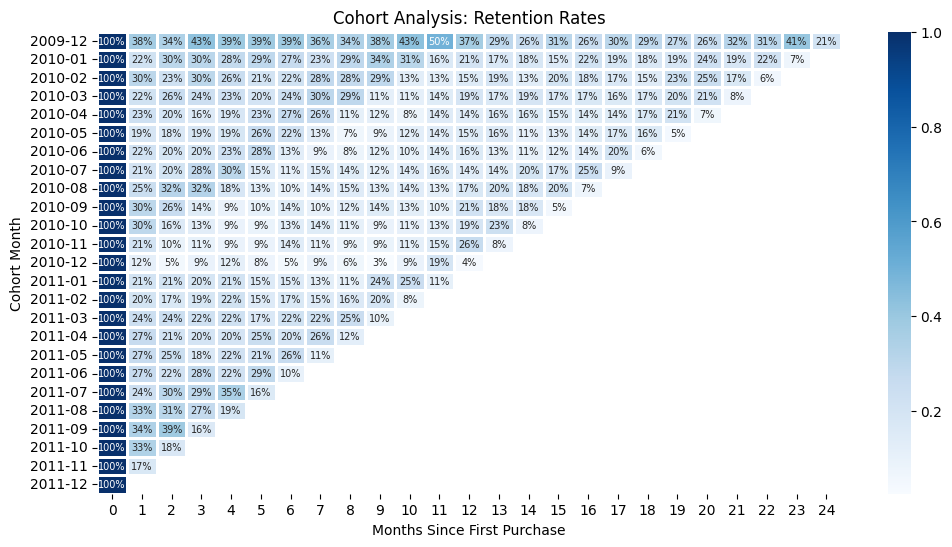

In [188]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues", linewidths=1, cbar=True, annot_kws={"size":7})
plt.title("Cohort Analysis: Retention Rates")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.yticks(rotation=0)
plt.show()

#### From the retention heatmap, initial customer retention in month 1 is consistently at 100%, as expected, but drops sharply in the second month to around 20–40% across cohorts. Most cohorts exhibit a steady decline over time, with few retaining more than 20% of customers after 6–12 months. Notably, the December 2009 and early 2010 cohorts show slightly higher long-term retention compared to later cohorts, although this may partly reflect the fact that the dataset combines two separate yearly snapshots (2009–2010 and 2010–2011), which inflates early-year cohorts and underrepresents later-year ones.

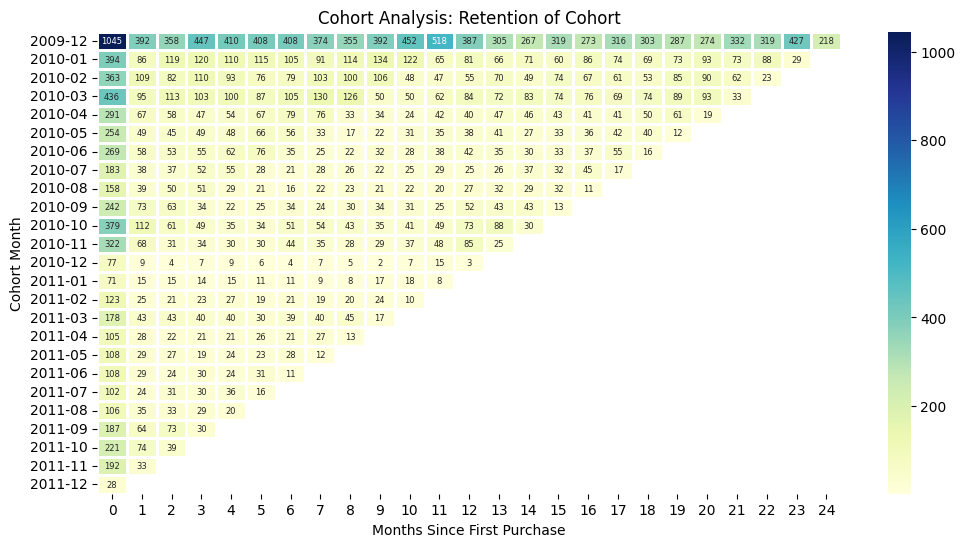

In [190]:
cohort_pivot = cohort_pivot.fillna(0).astype(int)
cohort_pivot = cohort_pivot.replace(0, np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_pivot, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=1, cbar=True, annot_kws={"size":6})
plt.title("Cohort Analysis: Retention of Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.yticks(rotation=0)
plt.show()

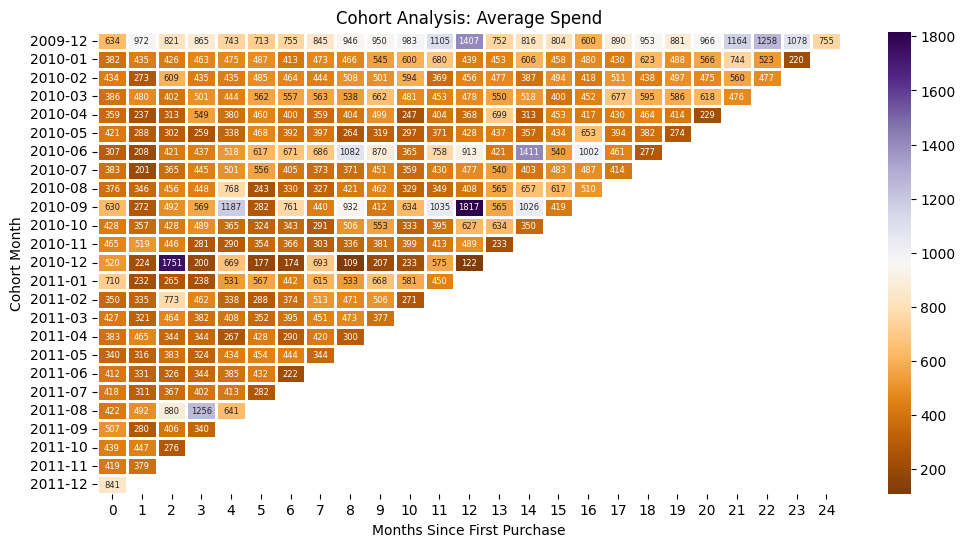

In [167]:
cohort_spend_pivot = cohort_counts.pivot(index='Cohort', columns='CohortIndex', values='AverageSpend')
cohort_spend_pivot = cohort_spend_pivot.fillna(0).astype(int)
cohort_spend_pivot = cohort_spend_pivot.replace(0, np.nan)
plt.figure(figsize=(12, 6))
sns.heatmap(cohort_spend_pivot, annot=True, cmap="PuOr", fmt=".0f", linewidths=1, cbar=True, annot_kws={"size":6})
plt.title("Cohort Analysis: Average Spend")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.yticks(rotation=0)
plt.show()

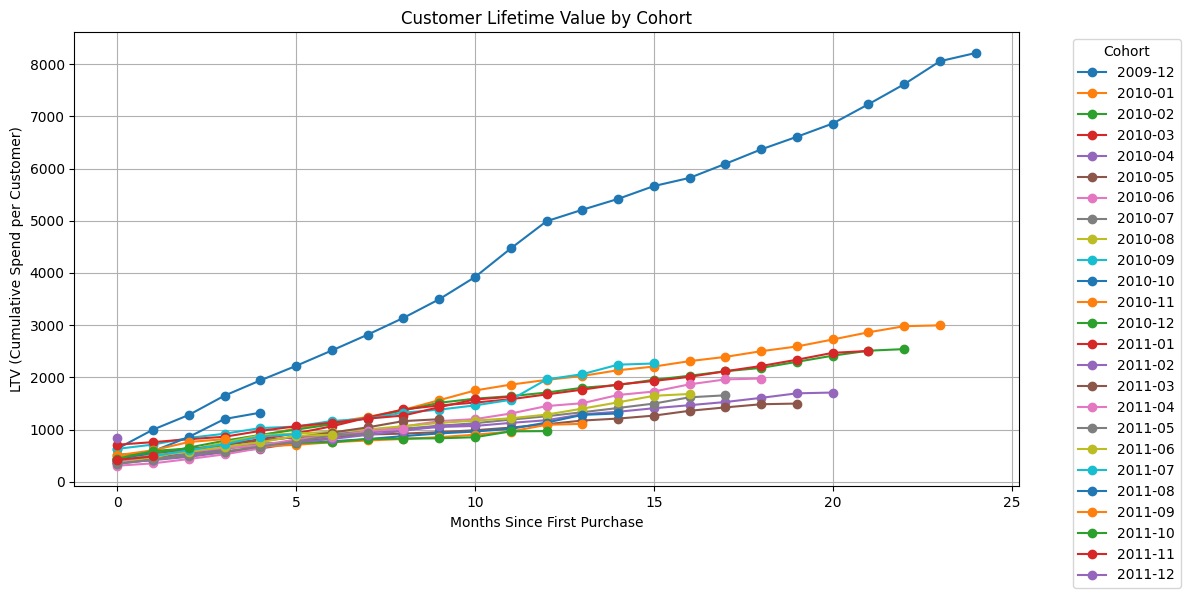

In [189]:
cohort_size = cohort_counts[cohort_counts.CohortIndex==0][['Cohort', 'CustomerID']].rename(columns={'CustomerID':'CohortSize'})
cohort_counts = cohort_counts.merge(cohort_size, on='Cohort')
cohort_counts['CumulativeSpend'] = cohort_counts.groupby('Cohort')['TotalSpend'].cumsum()
cohort_counts['LTV'] = cohort_counts['CumulativeSpend'] / cohort_counts['CohortSize']
ltv_pivot = cohort_counts.pivot(index='Cohort', columns='CohortIndex', values='LTV')

plt.figure(figsize=(12, 6))
for cohort in ltv_pivot.index:
    plt.plot(ltv_pivot.columns, ltv_pivot.loc[cohort], marker='o', label=str(cohort))
plt.title('Customer Lifetime Value by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('LTV (Cumulative Spend per Customer)')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# SUMMARY

**Before presenting recommendations, it’s important to note that the dataset appears to consist of two isolated yearly snapshots (2009–2010 and 2010–2011), rather than continuous customer lifecycle data from the company’s founding. This leads to artifacts in the cohorts — particularly artificially inflated January cohorts (which actually belong to earlier acquisition periods) and irregular cohort sizes later in each year. For the purpose of this exercise, however, we assume the data as presented reflects accurate, actionable information.**

---

Recommendations based on observed data:  

1. Spend more on getting new customers in December. We get fewer customers in December, but they're just as valuable as customers from other months. This suggests we're missing an opportunity.

2. Focus on keeping new customers engaged in their first month. Most customers leave between months 1 and 2, so improving the first-month experience could help more customers stay long-term.

3. Learn from our best customers. Customers from December 2009 and January 2010 are worth much more than recent customers. Figure out what we did differently back then and do it again.

4. Try new campaigns during summer months. Summer customers don't stay as long and we don't get as many. Test special offers during May-August to improve both.

5. Adjust how much we spend to get customers based on when we get them. Some customers are worth 3-4x more than others, so we can spend more to get customers during high-value months.